In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt

### Introduction to the Project
In this project, we aim to replicate and extend the findings of the paper "From Louvain to Leiden: guaranteeing well-connected communities". The paper critiques the widely-accepted Louvain community detection algorith by highlighting its underlying risk of producing disconnected communities and its relatively slow performance. Our project objectives are implementing both the Louvain and Leiden models, and comparing their modularity and speed to conclude that the Leiden algorithm outperforms the Louvain algorithm in terms of intra-community connectivity and model efficiency.

To test the functionality of both models, we will first utilize the well-known "Zachary's Karate Club" graph dataset from the Python library NetworkX. Furthermore, we will extend the original paper's analysis by evaluating the performance of the two models on real-world networks such as the Reddit network data, and comparing them with the Barabási–Albert model we learned in class.

##### Data

In [ ]:
G = nx.karate_club_graph()

### Louvain Algorithm Implementation

The Louvain algorithm is a popular method for community detection in large networks. It is named after the University of Louvain, where it was developed. The algorithm is known for its efficiency and simplicity, making it suitable for analyzing large-scale networks.

The architecture of the Louvain algorithm is based on a hierarchical clustering approach, which operates in two main phases that are repeated iteratively:

1. **Modularity Optimization:** The algorithm first assigns nodes to communities in a way that maximizes the modularity of the network. Modularity is the quality function for this model. It quantifies the density of connections within communities compared to connections between communities. The algorithm starts with each node in its own community and then, for each node, it evaluates the gain in modularity that would result from moving the node to the community of each of its neighbors. If a move increases the modularity, the step is
 performed. The whole process is repeated for all nodes until no further improvement in modularity can be achieved.

2. **Community Aggregation:** Once the first phase is complete, the algorithm creates a new network where each community from the previous phase is seen as a large "node". The weights of the edges between these newly formed large nodes are equal to the sum of the weights of the edges between nodes in the corresponding communities. The algorithm then applies the modularity optimization phase again on this aggregated network.

These two phases are repeated iteratively until the modularity cannot be increased further, indicating that the optimal community structure has been found.

The functions below implement the Louvain algorithm.

In [ ]:
def singleton_partition(G):
    """
    Create a partition where each node is in its own community.

    Args:
        G: The graph that will be partitioned.

    Returns:
        set of frozensets: A partition of the graph where each node is in its own singleton community.
    """
    return {frozenset({v}) for v in G.nodes()}

In [ ]:
P = singleton_partition(G)

In [ ]:
class Graph:
    """
    Represents a graph with a set of nodes and edges.

    Attributes:
        nodes (set): The set of nodes in the graph.
        edges (set): The set of edges in the graph, where each edge is represented as a tuple (node1, node2).
    """

    def __init__(self, nodes, edges):
        """
        Initializes a new Graph object.

        Args:
            nodes (set): The set of nodes for the graph.
            edges (set): The set of edges for the graph, where each edge is represented as a tuple (node1, node2).
        """
        self.nodes = nodes
        self.edges = edges

    def __repr__(self):
        """
        Returns a string representation of the graph.
        """
        return f"Graph(nodes={self.nodes}, edges={self.edges})"

    def draw(self):
        """
        Draws the graph using NetworkX and Matplotlib, displaying only the numbers for each node label.
        """
        G = nx.Graph()
        # Create a mapping from frozenset nodes to numbers
        node_labels = {node: list(node)[0] for node in self.nodes}
        G.add_nodes_from(node_labels.values())
        G.add_edges_from([(node_labels[u], node_labels[v]) for u, v in self.edges])
        nx.draw(G, with_labels=True, node_color='lightblue')
        plt.show()


In [ ]:

def aggregate_graph(G, P):
    """
    Creates an aggregate graph where each community in the partition becomes a node, and an edge is added between two nodes
    if there is at least one edge between the corresponding communities in the original graph.

    Args:
        G (graph): The original graph.
        P (set): The partition of the graph.

    Returns:
        Graph: The aggregate graph.
    """
    V = P
    E = set()
    for (u, v) in G.edges:
        for C in P:
            for D in P:
                if u in C and v in D:
                    E.add((C, D))
    return Graph(V, E)

In [ ]:
agg_graph = aggregate_graph(G,P)

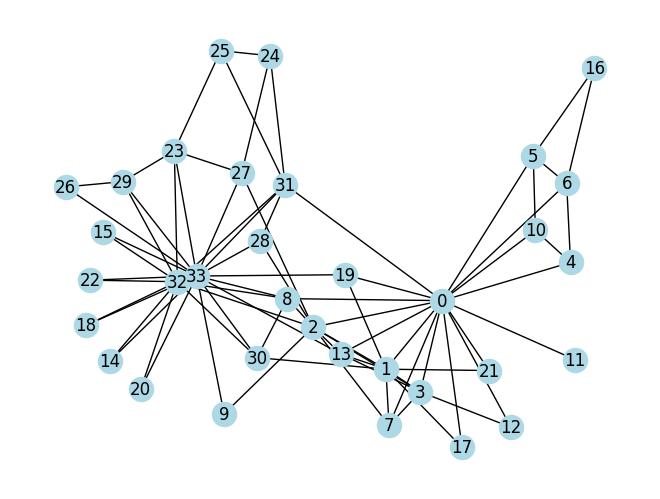

In [ ]:
agg_graph.draw()

Since this is the aggregate graph after single partition, the number on each node simply indicates the index of the node encoded in the original graph.

P (the partition) is a dictionary with int keys K representing nodes in the network and int values V representing the communities they belong to.

In [ ]:
import numpy as np

# num of edges between community C and community D, for instance
def get_edges_between_two_comms(comm1,comm2,G,P):
    res = 0
    def list_members(comm):
      return list(filter(lambda x : P[x] == comm,P.keys()))
    members1 = list_members(comm1)
    members2 = list_members(comm2)
    for node in members1:
      res += len(set(members2) & set(G[node]))
    return res

def get_edges_between_communities(G, P):
  counts = {}
  for i,k1 in enumerate(P.values()):
    for j,k2 in enumerate(P.values()):
      if i <= j:
        counts[k1,k2] = get_edges_between_two_comms(k1,k2)
  return counts

def H(G, P, gamma=1/7):
  total = 0
  counts = get_edges_between_communities(G, P) # E(C,D) in the paper
  for comm in P:
    total += counts[comm,comm] - ( gamma * math.comb(len(P[comm]), 2) )
  return total

def maybe_move_node(node, community, P):
  P_new = P
  for k in P_new:
    if node in P_new[k] and k != community:
      P_new[k].remove(node)
    elif node in P_new[k] and k == community:
      return P_new
  P_new[community].append(node)
  return P_new

def move_node(node, community, P):
  for k in P:
    if node in P[k] and k != community:
      P[k].remove(node)
    elif node in P[k] and k == community:
      return P
  P[community].append(node)
  return P

def move_nodes(G, P):
  while H(P) > H_old:
    H_old = H(P)
    for node in G:
      c_ = np.argmax(H(maybe_move_node(node, community, P)) - H(P) for community in P)
      if maybe_move_node(node, c_, P) - H(P) > 0:
        P = move_node(node, c_, P)
  return P

In [ ]:
def flattened(P):
  return [list(nodes) for nodes in P.values()]

def Louvain(G, P):
  done = False
  while not done:
    P = move_nodes(G, P)
    done = len(P)==len(G.nodes())#Terminate when each community consists of only one node, meaning that each node is its community
    if not done:
      G = aggregate_graph(G, P)
      P = singleton_partition(G)
  return flattened(P)


The Louvain algorithm lacks a mechanism to repair intra-disconnected communities. As a result, repeatedly applying the Louvain algorithm can be a double-edged sword: it may improve the community structure in some respects, but it can also lead to the deterioration of community cohesion.Furthermore, the presence of disconnected communities is just an extremity of a more general problem: communities detected by Louvain can be poorly connected in various degrees.

### Leiden Algorithm Implementation

The Leiden algorithm addresses the issue of disconnected communities present in the Louvain algorithm by introducing several enhancements. It speeds up the local moving of nodes and incorporates the concept of moving nodes to random neighbors. These improvements are considered among the most promising directions for enhancing the Louvain algorithm, although other suggestions have been made as well.

The Leiden algorithm comprises three phases: (1) local moving of nodes, (2) refinement of the partition, and (3) aggregation of the network based on the refined partition. It starts with a singleton partition and moves individual nodes between communities to find a better partition. This partition is then refined to optimize community cohesion. Unlike the Louvain algorithm, the Leiden algorithm includes an extra step of fine-tuning the groups for optimization.

An aggregate network is then created based on the refined partition, using the non-refined partition to create an initial partition for the aggregate network. The algorithm continues by moving individual nodes in the aggregate network, creating subgroups from the original groups, not the refined ones. In some cases, the refinement does not change the partition. These steps are repeated until no further improvements can be made, resulting in a more cohesive and well-connected community structure.

The punchline of Leiden is its refinement phase. Communities that are already defined during the initial partitioning phase may be further split into multiple sub communities during the refining phase. By creating the aggregate network based on refined partitioning rather than the original partitioning, the Leiden algorithm has more room for identifying high-quality partitions.

Importatnly, in the refinement phase, nodes are not necessarily greedily merged with the community that yields the largest increase in the quality function. Instead, a node may be merged with any community for which the quality function increases. Randomness in the selection of a community allows the partition space to be explored more broadly. Node mergers that cause the quality function to decrease are not considered, yielding this model more efficient than Louvain.

The functions below implement the Louvain algorithm. Note that the first two steps of leiden are exactly the same as louvain

In [ ]:
def singleton_partition(G):
    """
    Create a partition where each node is in its own community.

    Args:
        G: The graph that will be partitioned.

    Returns:
        set of frozensets: A partition of the graph where each node is in its own singleton community.
    """
    return {frozenset({v}) for v in G.nodes()}

def aggregate_graph(G, P):
    """
    Creates an aggregate graph based on a given partition of the original graph.

    In the aggregate graph, each community in the partition becomes a node, and an edge is added between two nodes
    if there is at least one edge between the corresponding communities in the original graph.

    Args:
        G (Graph): The original graph.
        P (set of frozensets): The partition of the graph, where each element is a set representing a community.

    Returns:
        Graph: The aggregate graph.
    """
    V = P
    E = set()
    node_to_community = {node: community for community in P for node in community}
    for (u, v) in G.edges:
        C = node_to_community[u]
        D = node_to_community[v]
        if C != D:
            E.add((C, D))
    return Graph(V, E)



In [ ]:
def partition_quality_change(G, P, v, new_C):
    """
    The quality function function that calculates the change in modularity when moving a node to a different community.

    Args:
        G (dict): The graph represented as an adjacency dictionary.
        P (dict): The current partition of the graph, where keys are nodes and values are communities.
        v (int): The node being moved.
        new_C (set): The new community to which the node is being moved.

    Returns:
        float: The change in modularity.
    """
    # Current community of node v
    old_C = P[v]

    # Degrees and total edge weight
    k_v = sum(G[v].values())
    m = sum(sum(G[u].values()) for u in G) / 2

    # Sum of degrees in the old and new communities
    k_old_C = sum(sum(G[u].values()) for u in old_C)
    k_new_C = sum(sum(G[u].values()) for u in new_C)

    # Edges between v and other nodes in the old and new communities
    e_v_old_C = sum(G[v][u] for u in old_C if u in G[v])
    e_v_new_C = sum(G[v][u] for u in new_C if u in G[v])

    # Change in modularity
    change_modularity = (e_v_new_C - e_v_old_C) / m - k_v * (k_new_C - k_old_C - k_v) / (2 * m**2)
    return change_modularity

gamma = 1
# the resolution parameter, controls the size of the communities detected by the algorithm.
# A higher value of gamma tends to result in smaller, more tightly-knit communities, while a
# lower value tends to produce larger, more inclusive communities.

# In the paper "For each network, we repeated the experiment 10 times. We used modularity with a
# resolution parameter of γ = 1 for the experiments."

theta = 0.1
# higher value of theta increases the likelihood of accepting moves that result in a smaller
# increase in partition quality, thereby introducing more randomness into the process.

def merge_nodes_subset(G, P, S):
    """
    Refines a given partition of a graph by merging well-connected nodes within a specified subset into communities.

    Args:
        G (dict): The graph inputted, where keys are nodes and values are dictionaries
                  of neighboring nodes with edge weights.
        P (dict): The current partition of the graph, where keys are nodes and values are communities.
        S (set): The subset of nodes within which to merge well-connected nodes.

    Returns:
        dict: The updated partition of the graph after merging well-connected nodes within the subset.
    """
    # Calculate the degree of each node and the subset
    k = {v: sum(G[v].values()) for v in S}
    k_S = sum(k.values())

    # Consider only nodes that are well connected within the subset
    R = {v for v in S if sum(G[v][u] for u in S if u != v) >= gamma * k[v] * (k_S - k[v])}

    for v in R:
        # Consider only nodes that are in singleton communities
        if P[v] == {v}:
            # Consider only well-connected communities
            T = {C for C in P.values() if C.issubset(S) and
                 sum(G[u][w] for u in C for w in S - C) >= gamma * sum(k[u] for u in C) * (k_S - sum(k[u] for u in C))}

            # Choose a random community to move the node to, based on a probability proportional to the change in partition quality
            delta_hp = {C: partition_quality_change(G, P, v, C) for C in T}
            prob = {C: np.exp(1 / theta * delta_hp[C]) if delta_hp[C] >= 0 else 0 for C in T}
            total_prob = sum(prob.values())
            if total_prob > 0:
                prob = {C: p / total_prob for C, p in prob.items()}
                chosen_community = np.random.choice(list(T), p=list(prob.values()))
                P[v] = chosen_community

    return P


Since the data size in Zachary's karate club is pretty small, the subset we will input into the "merge_nodes_subset" function is the high-degree nodes. We set the threshold to be 4, given that there are only 34 nodes in the network. For future implementation of a much larger network, like the Reddit network data, we will set the threshold higher.

In [ ]:
S = {node for node, degree in G.degree() if degree >= 4}


In [ ]:
merge_nodes_subset(G, P, S)

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

In [ ]:
def refine_partition(G, P):
    """
    Refine partitions by merging nodes within each community to form well-connected sub-communities.

    Args:
        G (dict): The graph inputted, where keys are nodes and values are dictionaries
                  of neighboring nodes with edge weights.
        P (dict): The initial partition of the graph, where keys are nodes and values are communities.

    Returns:
        dict: The refined partition of the graph, where nodes within each original community have been merged into
              well-connected sub-communities.
    """
    P_refined = singleton_partition(G)  # Assign each node to its own community
    for c in P.values():  # Visit communities
        P_refined = merge_nodes_subset(G, P_refined, c)  # Refine community
    return P_refined


In [ ]:
def move_nodes_fast(G, P):
    """
    Move nodes into partitions, quickly compared to the Louvain algorithm by
    checking neighbor membership.

    Args:
    G: nx.Graph object represented by a dictionary. Referencing G[v] should
      refer to the nodes adjacent (connected by an edge) to node v.
    P: Dictionary representing the communities a graph contains. The keys of the
      dict are nodes (ints) contained in G and the values are communities (ints)
      they belong to.

    Returns:
    P: Identical in data structure to the argument, but reorganized by this
      function.
    """
    Q = Queue(G.nodes())
    while Q:
      v = Q.get() # next node to visit
      c_ = np.argmax(H(maybe_move_node(node, community, P)) - H(P) for community in P) # find best community for node
      if H(maybe_move_node(node, c_, P)) - H(P) > 0: # If this is a better match for the node and a positive movement
          P = move_node(node, c_, P)  # move the node to that partition
          neighbors_v = []
          for u in G[v]:
            if P[v] != P[u]:
              neighbors_v.append(u)
      Q.put(neighbors_v) # Add the neighbors not sorted into the same partition to the queue
      ### Might be a bug here if you can't add a list to a queue, if so just += it
    return P # new set of partitions

def Leiden(G, P):
    done = False
    while not done:
        P = move_nodes_fast(G,P) # Partition the graph into communities
        done = (len(set(P.values())) == len(P))
        if done: # End and return when each community consists of one node
          break
        P_refined = refine_partition(G,P) # Refine the partition made by the fast move
        G = aggregate_graph(G,P)
    return flattened(P)